In [20]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

class OceanScape(Env):
    def __init__(self):
        super(OceanScape, self).__init__()

        # Define a 2-D observation space
        self.observation_shape = (600, 800, 3)
        self.canvas_size = self.observation_shape[:2]
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape),
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)

        # Define an action space ranging from 0 to 4
        #{0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}
        self.action_space = spaces.Discrete(5,)

        # Create a canvas to render the environment images upon
        self.canvas = np.ones(self.observation_shape) * 1

        # Define elements present inside the environment
        self.elements = []

        # Maximum battery can take at once
        self.max_battery = 1000

        # Permissible area of buoy to be
        self.y_min = int(self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]

        self.goal = [np.random.rand()* self.canvas_size[0],
                    np.random.rand()* self.canvas_size[1]]
                     # x and y
        print('goal: ', self.goal)
        self.goal_radius = 10


# I need to store all the visited points to plot them
# Agent will have full access to current environment and map
# (in future -- may make reality more complicated than ideal observation)


# reset to initial state: Fixed start and goal locations, Semi random wind
# field

    def reset(self):
        # Reset the fuel consumed
        self.batt_left = self.max_battery

        # Reset the reward
        self.ep_return = 0 


        # Determine a place to intialise the chopper in
        x = random.randrange(int(self.observation_shape[0] * 0.05), int(self.observation_shape[0] * 0.10))
        y = random.randrange(int(self.observation_shape[1] * 0.15), int(self.observation_shape[1] * 0.20))

        # Intialise the chopper
        self.buoy = Buoy("buoy", self.x_max, self.x_min, self.y_max, self.y_min)
        self.buoy.set_position(x,y)


        self.elements = [self.buoy]


        # Reset the Canvas
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas() # TODO: why this no work?


        # return the observation
        return self.canvas 

# Step: movement is omni, but fuel budget is reduced based on direction
    def inGoalRegion(self):
        #print(f'position {self.buoy.get_position()}, goal {self.goal}')
        #dist = np.linalg.norm(self.buoy.get_position() - self.goal) 
        b_x, b_y = self.buoy.get_position()
        
        dist = np.sqrt( (b_x - self.goal[0])**2 + (b_y - self.goal[1])**2)
        if dist < self.goal_radius:
            #print('distance', dist)
            print(f'hurray! in goal region {self.goal},'
                  ' posit {self.b_x}, {self.b_y}')
            return True
        return False


    def step(self, action):
        #print(action)
        # Flag that marks the termination of an episode
        done = False

        # Assert that it is a valid action
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the fuel counter
        self.batt_left -= 1

        # Reward for executing a step.
        reward = 1

        # apply the action to the chopper
        if action == 0:
            self.buoy.move(0,5)
        elif action == 1:
            self.buoy.move(0,-5)
        elif action == 2:
            self.buoy.move(5,0)
        elif action == 3:
            self.buoy.move(-5,0)
        elif action == 4:
            self.buoy.move(0,0)


        # Increment the episodic return
        if self.inGoalRegion(): 
            # giant pot for reaching end goal as a function of batt left
            self.ep_return += 0.1 * (self.max_battery - self.batt_left)
            print(f'reached goal, final return {self.ep_return}')
            done = True
        # else:
            #TODO: change this! Some heuristic I guess... Right now sparse
            # Reward is zero on all transitions, except those into the goal state, on which it is +1. After reaching the goal state (G), the agent returns to the start state (S) to begin a new episode.
        # If out of fuel, end the episode.
        if self.batt_left == 0:
            self.ep_return = -10
            print(f'oops ran out of battery, final return {self.ep_return}')
            done = True

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        return self.canvas, reward, done, []

# Render: renders wind field, current location, and visited locations, as
# well as start and goal locations
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas
# This is created on opencv2.  


    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}


    def close(self):
        cv2.destroyAllWindows()


    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        #def plot_path(self, path, cl='r', flag=False):
            #path_x = [path[i][0] for i in range(len(path))]
            #path_y = [path[i][1] for i in range(len(path))]

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon
            
            breadcrumbs = elem.get_history()

            for crumb in breadcrumbs:
                p_x, p_y = crumb
                # Use less efficient method for now 
                self.canvas = cv2.circle(self.canvas, (p_x, p_y), radius=2,
                                         color=(0, 0, 255), thickness=-1) 

        text = 'Batt Left: {} | Rewards: {}'.format(self.batt_left, self.ep_return)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (0,0,0), 1, cv2.LINE_AA)



class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name

        self.history = []
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

        self.history.append((self.x, self.y))

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

    def get_history(self):
        return self.history 


class Buoy(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Buoy, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("argo_buoy.png") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))



# NOTES: 
    # You can use cv2.circle() function opencv module:
    # image = cv.circle(image, centerOfCircle, radius, color, thickness)
    # Keep radius as 0 for plotting a single point and thickness as a negative number for filled circle


    



In [21]:
from IPython import display

env = OceanScape()
obs = env.reset()

while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render()

    if done == True:
        print('done')
        break

env.close()

/home/nrw/v3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


goal:  [409.5177767606199, 615.3709473843388]
done


goal:  [425.4419238745836, 603.744210580978]


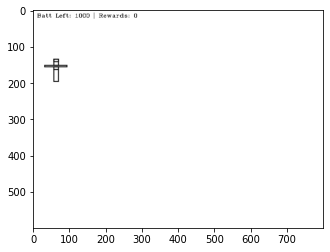

In [22]:
env = OceanScape()
obs = env.reset()
screen = env.render(mode = "rgb_array")
plt.imshow(screen)

In [20]:

env = ChopperScape()
obs = env.reset()


while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    # Render the game
    env.render()
    
    if done == True:
        break

env.close()

NameError: name 'ChopperScape' is not defined